In [18]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D


print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("Version:",tf.__version__)

import matplotlib.pyplot as plt
import time

Num GPUs Available: 1
Version: 2.5.0-rc1


In [19]:
#import dataset
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

In [20]:
# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

#Validation data
val_images = train_images [-2500:]
val_labels = train_labels [-2500:]

train_images = train_images[:-2500]
train_labels = train_labels[:-2500]

In [21]:
#Architecture
model = Sequential([
    Conv2D(32, 3, activation='relu', input_shape=(32, 32, 3), padding='same'),
    Conv2D(32, 3, activation='relu', padding='same'),
    MaxPooling2D(),

    Conv2D(64, 3, activation='relu', padding='same'),
    Conv2D(64, 3, activation='relu', padding='same'),
    MaxPooling2D(),

    Conv2D(128, 3, activation='relu', padding='same'),
    Conv2D(128, 3, activation='relu', padding='same'),
    MaxPooling2D(),

    Conv2D(256, 3, activation='relu', padding='same'),
    Conv2D(256, 3, activation='relu', padding='same'),
    MaxPooling2D(),

    Flatten(),
    Dense(512, activation='relu'),
    Dense(10)

])

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 128)        

In [23]:
#Compile model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
#Train model
batch_size = 32

startTime = time.time()
history = model.fit(train_images, train_labels, epochs=25, batch_size=batch_size,
                    validation_data=(test_images, test_labels))

finishTime = time.time()

Epoch 1/25
1485/1485 [==============================] - 16s 10ms/step - loss: 1.8660 - accuracy: 0.2830 - val_loss: 1.3642 - val_accuracy: 0.4992
Epoch 2/25
1485/1485 [==============================] - 17s 11ms/step - loss: 1.2282 - accuracy: 0.5584 - val_loss: 0.9883 - val_accuracy: 0.6529
Epoch 3/25
1485/1485 [==============================] - 16s 11ms/step - loss: 0.9419 - accuracy: 0.6674 - val_loss: 0.9484 - val_accuracy: 0.6704
Epoch 4/25
1485/1485 [==============================] - 14s 10ms/step - loss: 0.7939 - accuracy: 0.7218 - val_loss: 0.8697 - val_accuracy: 0.7033
Epoch 5/25
1485/1485 [==============================] - 14s 9ms/step - loss: 0.6556 - accuracy: 0.7709 - val_loss: 0.8027 - val_accuracy: 0.7280
Epoch 6/25
1485/1485 [==============================] - 14s 9ms/step - loss: 0.5711 - accuracy: 0.7975 - val_loss: 0.8489 - val_accuracy: 0.7319
Epoch 7/25
1485/1485 [==============================] - 14s 9ms/step - loss: 0.5096 - accuracy: 0.8174 - val_loss: 0.7859 - va

In [25]:
#Print train time
timeTaken = finishTime - startTime
minutes = timeTaken // 60
seconds = round((timeTaken % 60), 1)
print(f"Time taken: {minutes}m, {seconds}s" )

Time taken: 5.0m, 54.3s


In [26]:
#Evaluate model with test set
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2, batch_size=batch_size)
print(f'\nTest accuracy: {round(test_acc,4) * 100}%')

313/313 - 1s - loss: 1.3716 - accuracy: 0.7286

Test accuracy: 72.86%


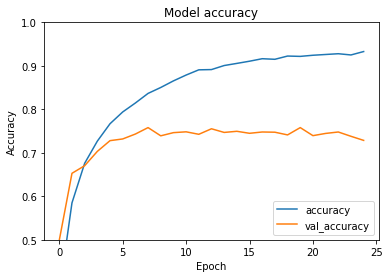

In [27]:
#Plot accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

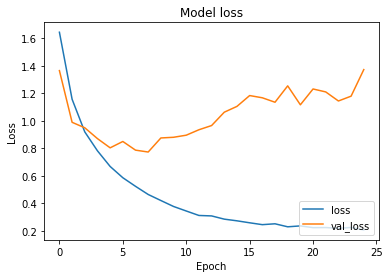

In [28]:
#Plot loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(loc='lower right')
plt.show()